In [7]:
from deep4cast.forecasters import Forecaster
import deep4cast.metrics as metrics
from deep4cast.custom_layers import *

import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pyodbc
import warnings

warnings.simplefilter('ignore')

%matplotlib inline

In [8]:
def _standardize(data, locked=False):
        """Standardize numpy array in a NaN-friendly way.

        :param data: Input time series.
        :type data: numpy array
        :param data: Boolean that locks down the scales of the data.
        :type data: boolean

        """
        # Use numpy.nanmean/nanstd to handle potential nans when
        # when standardizing data. Make sure to keep a lock on
        # internal variables during prediction step.
        if not locked:
            # By default the data scale is set by the standard deviation,
            # but we need to handle the case where the standard deviation
            # or the mean is zero.
            means = np.nanmean(data, axis=0)
            scales = np.nanstd(data, axis=0)

            # Check for small scales in stds.
            ind = np.where(scales < 1e-16)
            scales[ind] = means[ind]

            # Check again for means.
            ind = np.where(scales < 1e-16)
            scales[ind] = 1.0

            data_means = means
            data_scales = scales
        return (data - data_means) / data_scales, means, scales
    
def _unstandardize(data, means, scales):
        """Un-standardize numpy array."""
        
        # Unstandardize taking presence of covariates into account.
        
        return data * scales + means

# Dataset

(7588, 8)


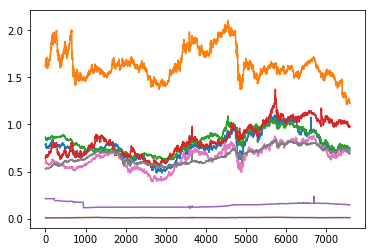

In [9]:
ex_rate_dataset = pd.read_csv('../data/exchange_rate.txt', parse_dates=False,header=-1, index_col=False)
ex_rate_dataset = ex_rate_dataset.values
print(ex_rate_dataset.shape)
plt.plot(ex_rate_dataset)
plt.show()

# Model

In [10]:
from keras.layers import Input, Dense, Lambda, concatenate, GRU
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras import backend as K


def fit_model(nb_epoch, batch_size, X, Y):
    inds = np.arange(len(X))
    np.random.seed(10)
    np.random.shuffle(inds)
    X = X[inds]
    Y = Y[inds]
    if K.backend() == 'tensorflow':
        K.clear_session()
    
    D = X.shape[2]
    inp = Input(shape=(X.shape[1],X.shape[2]))
    x = inp
    x = GRU(128, activation='tanh')(x)
    x = MCDropout(0.1)(x)
    mean = Dense(D)(x)
    mean = MCDropout(0.1)(mean)
    log_var = Dense(D)(x)
    log_var = MCDropout(0.1)(log_var)
    out = concatenate([mean, log_var])
    model = Model(inp, out)
    
    def heteroscedastic_loss(true, pred):
        mean = pred[:, :D]
        log_var = pred[:, D:]
        precision = K.exp(-log_var)
        return K.sum(precision * (true - mean)**2. + log_var, -1)
    
    model.compile(optimizer='adam', loss=heteroscedastic_loss)
    print(model.summary())
#     assert len(model.layers[1].trainable_weights) == 3  # kernel, bias, and dropout prob
#     assert len(model.losses) == 5  # a loss for each Concrete Dropout layer
    es = EarlyStopping(monitor='val_loss', min_delta=0, patience=20)
    
    
    hist = model.fit(X, Y, nb_epoch=nb_epoch, batch_size=batch_size, verbose=2, callbacks=[es],
            validation_split=0.20, shuffle=False)
    loss = hist.history['loss'][-1]
    return model, -0.5 * loss



In [ ]:
#Multiple resolutions of our model
steps = [1, 2, 5, 10, 25, 50]
ts = ex_rate_dataset
lag = 500 
final_horizon = 50
horizon = 1 
test_length = int(0.3*ts.shape[0])
ts, means, scales = _standardize(ts)
print(ts.shape)

train = []
train_label = []
test = []
test_label = []
model = []

batch_size=256
epochs = 300

for step in steps:
    rolling_steps = int(final_horizon/step) - 1
    sub_lag = int(lag/step)
    ts_train = []
    ts_train_label = []
    
    for i in range(ts.shape[0]-(sub_lag-1+horizon)*step):    
        indices = [i + step*j for j in range(sub_lag)]
        ts_train.append(np.take(ts, indices, axis=0))
        ts_train_label.append(np.take(ts, i+step*(sub_lag-1+horizon), axis =0))
    
    
    ts_test = np.array(ts_train[-test_length-rolling_steps:])
    ts_test_label = np.array(ts_train_label[-test_length-rolling_steps:])
    ts_train = np.array(ts_train[:-test_length-rolling_steps])
    ts_train_label = np.array(ts_train_label[:-test_length-rolling_steps])

    print(ts_train.shape)
    print(ts_train_label.shape)
    print(ts_test.shape)
    print(ts_test_label.shape)
    
    train.append(ts_train)
    train_label.append(ts_train_label)
    test.append(ts_test)
    test_label.append(ts_test_label)
    
    each_model, ELBO = fit_model(epochs,batch_size, ts_train, ts_train_label)
    
    
    
    #save models
    model.append(each_model)
    
    


(7588, 8)
(4763, 500, 8)
(4763, 8)
(2325, 500, 8)
(2325, 8)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 500, 8)       0                                            
__________________________________________________________________________________________________
gru_1 (GRU)                     (None, 128)          52608       input_1[0][0]                    
__________________________________________________________________________________________________
mc_dropout_1 (MCDropout)        (None, 128)          0           gru_1[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 8)            1032        mc_dropout_1[0][0]               
_________________________________________________

Train on 3830 samples, validate on 958 samples
Epoch 1/300
 - 15s - loss: 3.6420 - val_loss: 0.1503
Epoch 2/300
 - 14s - loss: -1.5713e+00 - val_loss: -3.4147e+00
Epoch 3/300
 - 14s - loss: -4.8729e+00 - val_loss: -5.8769e+00
Epoch 4/300
 - 14s - loss: -6.8129e+00 - val_loss: -8.0697e+00
Epoch 5/300
 - 14s - loss: -8.6050e+00 - val_loss: -9.2442e+00
Epoch 6/300
 - 14s - loss: -9.6193e+00 - val_loss: -1.0163e+01
Epoch 7/300
 - 14s - loss: -1.0376e+01 - val_loss: -1.0890e+01
Epoch 8/300
 - 14s - loss: -1.0871e+01 - val_loss: -1.1183e+01
Epoch 9/300
 - 14s - loss: -1.1066e+01 - val_loss: -1.1421e+01
Epoch 10/300
 - 14s - loss: -1.1377e+01 - val_loss: -1.2133e+01
Epoch 11/300
 - 14s - loss: -1.1708e+01 - val_loss: -1.1540e+01
Epoch 12/300
 - 11s - loss: -1.1632e+01 - val_loss: -1.1859e+01
Epoch 13/300
 - 12s - loss: -1.1988e+01 - val_loss: -1.2100e+01
Epoch 14/300
 - 13s - loss: -1.2008e+01 - val_loss: -1.2478e+01
Epoch 15/300
 - 12s - loss: -1.2164e+01 - val_loss: -1.2307e+01
Epoch 16/300

# Prediction

In [ ]:
for model_i in model:
    
    